In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Create databunch from folder
Download the data using the script https://www.kaggle.com/nlecoy/imaterialist-downloader-util
Use wget chrome extension to download the json files in google cloud.
next use the script as,
```
python <file_name>.py test.json "C:\Users\userName\Downloads\test"
```
The script will download max of 10K files. We can change that when required.

In [3]:
path = Config.data_path()/'imaterialist'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/imaterialist')

In [4]:
! ls -ltr /home/jupyter/.fastai/data/imaterialist/train | head

total 619736
-rw-r--r-- 1 jupyter jupyter  31914 Mar  4 08:54 12.jpg
-rw-r--r-- 1 jupyter jupyter  45358 Mar  4 08:54 8.jpg
-rw-r--r-- 1 jupyter jupyter  79905 Mar  4 08:54 2.jpg
-rw-r--r-- 1 jupyter jupyter  61237 Mar  4 08:54 11.jpg
-rw-r--r-- 1 jupyter jupyter  58387 Mar  4 08:54 10.jpg
-rw-r--r-- 1 jupyter jupyter  45001 Mar  4 08:54 5.jpg
-rw-r--r-- 1 jupyter jupyter  42898 Mar  4 08:54 6.jpg
-rw-r--r-- 1 jupyter jupyter  33402 Mar  4 08:54 3.jpg
-rw-r--r-- 1 jupyter jupyter  60731 Mar  4 08:54 1.jpg
ls: write error: Broken pipe


In [5]:
def get_df(folder_name):
    imgs = list((path/folder_name).glob('**/*.jpg'))
    imgs_name = set([i.stem for i in imgs])
    f = (path/folder_name).with_suffix('.json')
    jsonf = json.load(open(f))
    for i in jsonf['annotations']:
        i['labelId']  = ' '.join(i['labelId'])
    df = pd.DataFrame([i for i in jsonf['annotations'] if i['imageId'] in imgs_name] )
    return df

valid_df = get_df('valid')
valid_df.head()

,imageId,labelId
0,1,62 17 66 214 105 137 85
1,2,95 17 66 214 164 137 20 204 184
2,3,122 19 66 186 180 44 154 20
3,4,190 222 66 153 164 226 53 184
4,5,62 66 153 171 111 137 70 204 184


In [6]:
train_df = get_df('train')
train_df.head()

,imageId,labelId
0,1,95 66 137 70 20
1,2,36 66 44 214 105 133
2,3,170 66 97 153 105 138
3,4,18 66 44 153 164
4,5,189 66 176 137 153 74 181 171 138


In [7]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
np.random.seed(42)

In [9]:
train_labels = [i.split() for i in train_df['labelId'].values]
valid_labels = [i.split() for i in valid_df['labelId'].values]

In [75]:
# data=(ImageItemList.from_folder(path)
#     .split_by_folder()
#     .label_from_lists(train_labels=train_labels, valid_labels=valid_labels)
#     .add_test_folder()
#     .transform(tfms, size=64)
#     .databunch()
#     .normalize(imagenet_stats))

In [71]:
# data.show_batch(rows=3, figsize=(12,9))

In [11]:
train_df['imageId']  = ('train/' + train_df['imageId'] + '.jpg')

In [15]:
src = (ImageItemList.from_df(train_df, path)
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' ')
      )
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

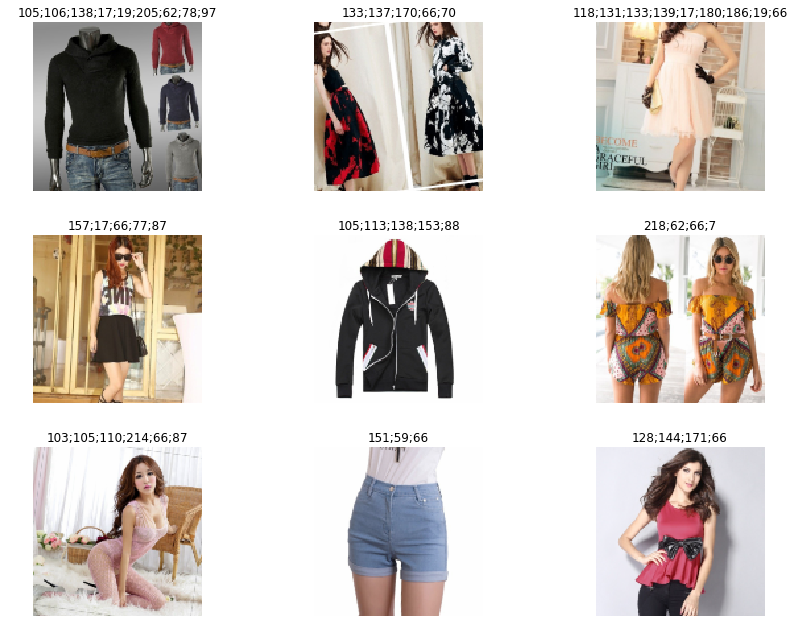

In [16]:
data.show_batch(rows=3, figsize=(12,9))

In [17]:
arch = models.resnet50

In [18]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-02


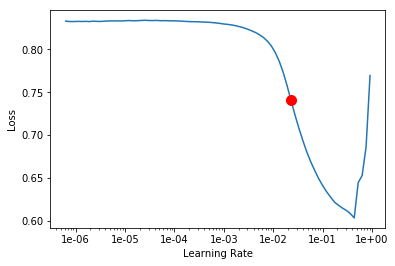

In [20]:
learn.recorder.plot()

In [21]:
lr = 0.01

In [22]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.223027,0.076331,0.971061,0.421193
2,0.087280,0.069914,0.971357,0.475443
3,0.072949,0.067710,0.972068,0.490584
4,0.067784,0.065911,0.973505,0.501888
5,0.064672,0.065304,0.972802,0.511111


In [23]:
learn.save('stage-1-rn50-train-split')

In [28]:
# added with split
learn.fit_one_cycle(5, slice(lr), wd=1e-4,)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.066463,0.067558,0.972861,0.491177
2,0.069273,0.066175,0.972230,0.506686
3,0.066299,0.064778,0.972800,0.521247
4,0.063216,0.064042,0.973330,0.524140
5,0.060268,0.063634,0.972643,0.534610


In [29]:
learn.fit_one_cycle(20, slice(lr), wd=1e-4,)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.059571,0.063660,0.972984,0.532272
2,0.060238,0.063940,0.972591,0.534356
3,0.060498,0.064917,0.972868,0.525544
4,0.061808,0.064927,0.972616,0.526464
5,0.062503,0.064997,0.972775,0.522969
6,0.062296,0.065106,0.972586,0.528724
7,0.061852,0.065011,0.971748,0.529223
8,0.060783,0.064834,0.974341,0.524670
9,0.060141,0.064781,0.973100,0.528786
10,0.059217,0.064621,0.972293,0.536672


In [81]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


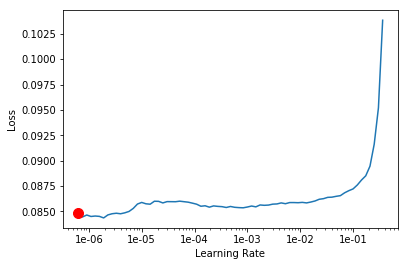

In [82]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.085888,0.121291,0.959337,0.275525
2,0.086434,0.121145,0.959090,0.279690
3,0.085608,0.121861,0.958859,0.267957
4,0.082651,0.123591,0.958553,0.266892
5,0.079533,0.124260,0.958439,0.262511


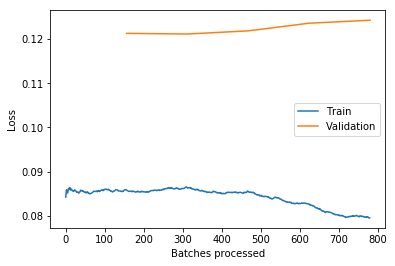

In [84]:
learn.recorder.plot_losses()

In [85]:
learn.save('stage-2-256-rn50')

In [86]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [87]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [88]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [89]:
df = pd.DataFrame({'image_id':fnames, 'label_id':labelled_preds}, columns=['image_id', 'label_id'])

In [90]:
df.to_csv(path/'submission.csv', index=False)

In [95]:
from IPython.display import FileLink, FileLinks
FileLink((path/'submission.csv').as_posix())

/home/jupyter/.fastai/data/imaterialist/submission.csv